In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# eigenvec_df = pd.read_csv("../data/eigenvec_original_10PC.csv", index_col=[0])
# eigenvec_df = pd.read_csv("../data/eigenvec_1000PC.csv", index_col=[0])
eigenvec_df = pd.read_csv("data/eigenvec_100PC.csv", index_col=[0])
who_variants = pd.read_csv("analysis/who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("data/drug_gene_mapping.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("data/combined_lineages_samples.csv", low_memory=False).query("sample_id in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append("utils")
from stats_utils import *

coll2014 = pd.read_csv("data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambubtol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

solo_results = pd.read_excel("data/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

if len(solo_results) == 1:
    solo_results = solo_results[list(solo_results.keys())[0]]
    
print(len(solo_results.drug.unique()))

# hard coded paths to preserve the model hierarchy
binary_analyses_lst = [
                        "tiers=1/phenos=WHO",
                        "tiers=1+2/phenos=WHO",
                        "tiers=1/phenos=ALL",
                        "tiers=1+2/phenos=ALL"
                      ]

model_names = ["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos"]
path_name_dict = dict(zip(binary_analyses_lst, model_names))

(49113, 6)
16


In [2]:
# for drug in os.listdir(analysis_dir):
    
#     for path in binary_analyses_lst:
        
#         fNames = glob.glob(f"{analysis_dir}/{drug}/BINARY/{path}/*.csv") + glob.glob(f"{path}/*.txt")
#         for fName in fNames:
#             os.remove(fName)

# Implement Catalog Method Using V1 Results

In [5]:
# def get_catalog_metrics(df_phenos, AF_thresh=0.75):

#     # for computing AUC, set AF to 0 for isolates below the threshold. This is because they are all classified as S anyway
#     df_phenos.loc[df_phenos["variant_allele_frequency"] < AF_thresh, "variant_allele_frequency"] = 0
    
#     # samples with a Cat 1 variant at an AF greater than or equal to the threshold are predicted R 
#     df_phenos.loc[df_phenos["variant_allele_frequency"] >= AF_thresh, "binary_pred"] = 1
#     df_phenos["binary_pred"] = df_phenos["binary_pred"].fillna(0).astype(int)
    
#     TN, FP, FN, TP = sklearn.metrics.confusion_matrix(y_true=df_phenos["phenotype"].values, y_pred=df_phenos["binary_pred"].values).ravel()
    
#     return pd.DataFrame({"Sens": TP / (TP + FN), 
#                          "Spec": TN / (TN + FP), 
#                          "Precision": TP / (TP + FP),
#                          "AUC": sklearn.metrics.roc_auc_score(y_true=df_phenos["phenotype"], y_score=df_phenos["variant_allele_frequency"]),
#                          "Accuracy": sklearn.metrics.accuracy_score(y_true=df_phenos["phenotype"].values, y_pred=df_phenos["binary_pred"].values),
#                          "Balanced_Acc": sklearn.metrics.balanced_accuracy_score(y_true=df_phenos["phenotype"].values, y_pred=df_phenos["binary_pred"].values)
#                         }, index=[0])

In [3]:
# def classify_using_V1_catalog(drug, AF_thresh, num_bootstrap=1000):
    
#     drug_abbr = drug_abbr_dict[drug]
#     drug_cat1_variants = who_variants.query("drug==@drug_abbr & confidence == '1) Assoc w R'")
    
#     if len(drug_cat1_variants) == 0:
#         print(f"No category 1 mutations for {drug}")
#         return None, None
    
#     drug_cat1_variants[["gene", "variant"]] = drug_cat1_variants["mutation"].str.split("_", expand=True)
#     cat1_genes = drug_cat1_variants.gene.unique()
#     cat1_variants = drug_cat1_variants["variant"].values

#     if 2 not in drug_gene_mapping.query("Drug==@drug & Gene in @cat1_genes").Tier.unique():
#         print("Reading in Tier 1 genes only")
#         df_genos = pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz"))
#     else:
#         print("Reading in Tier 1 and 2 genes")
#         df_genos = pd.concat([pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz")),
#                               pd.read_csv(os.path.join(analysis_dir, drug, "genos_2.csv.gz"))
#                              ])

#     # keep only samples that are in the genotypes dataframe
#     df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
#     df_phenos = df_phenos.query("sample_id in @df_genos.sample_id.values").reset_index(drop=True)
    
#     # merge with genotypes to get allele fractions for every variant. keep only Cat 1 variants because those are what the prediction will be based on
#     df_phenos = df_phenos.merge(df_genos.query("variant_category in @cat1_variants")[["sample_id", "variant_allele_frequency"]].sort_values("variant_allele_frequency", ascending=False).drop_duplicates("sample_id", keep="first"),
#                     on="sample_id", how="left"
#                    )

#     # drop NaNs, which are isolates that didn't pass quality control
#     df_phenos = df_phenos.dropna(subset='variant_allele_frequency', axis=0).reset_index(drop=True)
    
#     ALL_results = get_catalog_metrics(df_phenos, AF_thresh)
#     ALL_results["CV"] = 0
    
#     print(f"Performing {num_bootstrap}x bootstrapping for the ALL dataset")
    
#     for i in range(num_bootstrap):
#         bs_idx = np.random.choice(df_phenos.index.values, size=len(df_phenos), replace=True)
#         df_bs = df_phenos.iloc[bs_idx]
        
#         single_rep_results = get_catalog_metrics(df_bs, AF_thresh)
#         single_rep_results["CV"] = i + 1
#         ALL_results = pd.concat([ALL_results, single_rep_results], axis=0)
        
#     del df_bs
#     df_WHO = df_phenos.query("phenotypic_category == 'WHO'").reset_index(drop=True)
#     del df_phenos
    
#     WHO_results = get_catalog_metrics(df_WHO, AF_thresh)
#     WHO_results["CV"] = 0

#     print(f"Performing {num_bootstrap}x bootstrapping for the WHO dataset")
    
#     for i in range(num_bootstrap):
#         bs_idx = np.random.choice(df_WHO.index.values, size=len(df_WHO), replace=True)
#         df_bs = df_WHO.iloc[bs_idx]
        
#         single_rep_results = get_catalog_metrics(df_bs, AF_thresh)
#         single_rep_results["CV"] = i + 1
#         WHO_results = pd.concat([WHO_results, single_rep_results], axis=0)
        
#     WHO_results["CV"] = WHO_results["CV"].astype(int)
#     ALL_results["CV"] = ALL_results["CV"].astype(int)
    
#     # add dummy variables of 0 for the AUCs so that it doesn't interfere with adding plot labels. The 0 bar doesn't get plotted because it is 0
#     WHO_results["Model"] = "V1 Catalogue,\nWHO Phenos"
#     ALL_results["Model"] = "V1 Catalogue,\nALL Phenos"
        
# #     # add dummy variables of 0 for the AUCs so that it doesn't interfere with adding plot labels. The 0 bar doesn't get plotted because it is 0
# #     WHO_results[["Model", "AUC"]] = ["V1 Catalogue,\nWHO Phenos", 0]
# #     ALL_results[["Model", "AUC"]] = ["V1 Catalogue,\nALL Phenos", 0]
    
#     return WHO_results, ALL_results

# Plot Sensitivity, Specificity, and AUC for Each Drug with Bootstrapped Confidence Intervals

In [2]:
def single_drug_bar_chart(drug, variable_lst, include_het=False, binary_analyses_lst=binary_analyses_lst, bootstrap=False, errorbar=None, palette="muted", sigfig=1, saveName=None):
    
    concat_models = []
    
    if include_het:
        model_prefix = "_HET"
    else:
        model_prefix = ""
        
    if bootstrap:
        model_prefix += "_bootstrap"
        
    if drug == "Pretomanid":
        binary_analyses_lst = [path for path in binary_analyses_lst if "ALL" in path and "1+2" not in path]
    
    hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos"]
    #hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nWHO Phenos", "V1 Catalogue,\nALL Phenos"]
        
    for path in binary_analyses_lst:
        
        if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv")):
            df = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv"))
        else:
            df = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path.replace("tiers=1+2", "tiers=1"), f"model_stats_CV{model_prefix}.csv"))
        
        df["Model"] = path_name_dict[path]
        concat_models.append(df)

    df_plot = pd.concat(concat_models, axis=0)
    
        
    # if there is no HET in the model prefix, use threshold of 0.75. If HET, use threshold of 0.25
    if include_het:
        AF_thresh = 0.25
        title_str = "+HET"
    else:
        AF_thresh = 0.75
        title_str = "-HET"
        
    #catalog_WHO, catalog_ALL = classify_using_V1_catalog(drug, AF_thresh, num_bootstrap=1000)
    catalog_WHO = None
    catalog_ALL = None
    df_plot = pd.concat([df_plot, catalog_WHO, catalog_ALL], axis=0)

    df_plot = df_plot.melt(id_vars=["Model"])
    df_plot["variable"] = df_plot["variable"].replace("Sens", "Sensitivity").replace("Spec", "Specificity").replace("Balanced_Acc", "Balanced Accuracy")
    df_plot = df_plot.query("variable in @variable_lst")#.query("CV > 0")
    df_plot["value"] *= 100
    
    # if catalog_WHO is not None:
    #     plot_width = 8
    #     hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nWHO Phenos", "V1 Catalogue,\nALL Phenos"]
    #     # x_order = ["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "V1 Catalogue,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nALL Phenos"]
    # else:
    #     plot_width = 6
    #     hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos"]
    #     # x_order=["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos"]
    plot_width = 2 * len(df_plot["variable"].unique())       
    palette = list(sns.color_palette("Paired").as_hex())
    
    # first pair is blue, second is orange, third is green, fourth is purple
    palette = palette[:2] + palette[6:8] + palette[2:4] + palette[8:10]
    
    fig, ax = plt.subplots(figsize=(plot_width, 4))
    sns.barplot(data=df_plot,
                x="variable",
                y="value",
                hue="Model",
                hue_order=hue_order,
                order=variable_lst,
                errorbar=errorbar,
                errwidth=0.75,
                capsize=0.05,
                palette=palette,
                ax=ax
                )
    
    # bar_scale = 0.8
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
        
    label_loc = 'center'
    
    if sigfig == 1:
        font_size = '8'
    else:
        font_size = '10'

    for cont in ax.containers:
        labels = [np.round(val, sigfig) if val > 0 else "" for val in cont.datavalues]    
        ax.bar_label(cont, labels=labels, label_type=label_loc, fontsize=font_size)

    plt.ylim(0, 100)
    plt.title(f"{drug} Models\n")
    plt.xlabel("")
    plt.ylabel("")
    sns.move_legend(ax, fontsize=8, title='', loc='upper right', #bbox_to_anchor=(1.12, 0.6)
                    ncol=len(df_plot["Model"].unique()) / 2, bbox_to_anchor=(0.7, -0.1)
                   )

    sns.despine()
    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300)
        
    return df_plot


def significance_test_HET_results(DROP_results, HET_results, variable_lst):
                    
    for var in variable_lst:
        
        x_var = DROP_results.query("CV > 0")[var].values
        y_var = HET_results.query("CV > 0")[var].values
        
        if st.normaltest(x_var) and st.normaltest(y_var):
            test_type = "parametric"
        else:
            test_type = "non"
        
        # alternative hypothesis is that the model with HETs is better
        if test_type == "parametric":
            _, pval = st.ttest_ind(x_var, y_var, alternative='two-sided', equal_var=False)
        else:
            _, pval = st.mannwhitneyu(x_var, y_var, alternative='two-sided')
        
        if pval < 0.05:
            
            mean_diff = np.mean(y_var) - np.mean(x_var)
            
            if test_type == "parametric":
                _, pval = st.ttest_ind(x_var, y_var, alternative='less', equal_var=False)
            else:
                _, pval = st.mannwhitneyu(x_var, y_var, alternative='less')
            
            if pval < 0.05:
                print(f"{var}: HET +{np.round(mean_diff, 2)}")
            else:
                if test_type == "parametric":
                    _, pval = st.ttest_ind(x_var, y_var, alternative='greater', equal_var=False)
                else:
                    _, pval = st.mannwhitneyu(x_var, y_var, alternative='greater')

                if pval < 0.05:
                    print(f"{var}: HET -{np.round(-mean_diff, 4)}")

In [3]:
# Levofloxacin: sens = 84.6, spec = 97

In [4]:
# very bad, not very informative results. Just compare mutations for PTM
# drug = "Pretomanid"
# # 695/5, 
# # variable_lst = ["AUC", "Sens", "Spec"]#, "Balanced_Acc"]

# plot_everything_check_significance(drug)

In [5]:
# drug = "Pretomanid"
# PTM_results, PTM_het_results = plot_everything_check_significance(drug, variable_lst=["AUC"])#saveName_DROP="results/TBScience/BDQ_no_HETs.png", saveName_HET="results/TBScience/BDQ_with_HETs.png")

In [114]:
drug = "Bedaquiline"
path = 'tiers=1+2/phenos=ALL'
variable_lst = ["Sens", "Spec", "AUC", "Balanced_Acc"]
results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_bootstrap.csv"))
HET_results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_HET_bootstrap.csv"))

significance_test_HET_results(results, HET_results, variable_lst)

Sens: HET +0.02
Spec: HET -0.0022
AUC: HET +0.01
Balanced_Acc: HET +0.01


In [115]:
drug = "Levofloxacin"
path = 'tiers=1+2/phenos=ALL'
variable_lst = ["Sens", "Spec", "AUC", "Balanced_Acc"]
results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_bootstrap.csv"))
HET_results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_HET_bootstrap.csv"))

significance_test_HET_results(results, HET_results, variable_lst)

Sens: HET +0.01
Spec: HET -0.0045
AUC: HET +0.0
Balanced_Acc: HET +0.0


In [69]:
np.percentile(BDQ_HET_results["Accuracy"], q=[2.5, 97.5])

array([0.91839479, 0.92879892])

In [66]:
np.mean(BDQ_results["Accuracy"])

0.9250433242417784

In [78]:
st.normaltest(BDQ_results["Accuracy"])[1], st.normaltest(BDQ_HET_results["Accuracy"])[1]

(3.8831529356799404e-05, 1.0534967777069153e-20)

(array([ 31., 108., 290., 320., 182.,  55.,   9.,   2.,   2.,   2.]),
 array([0.91634227, 0.91854342, 0.92074457, 0.92294571, 0.92514686,
        0.92734801, 0.92954915, 0.9317503 , 0.93395145, 0.93615259,
        0.93835374]),
 <BarContainer object of 10 artists>)

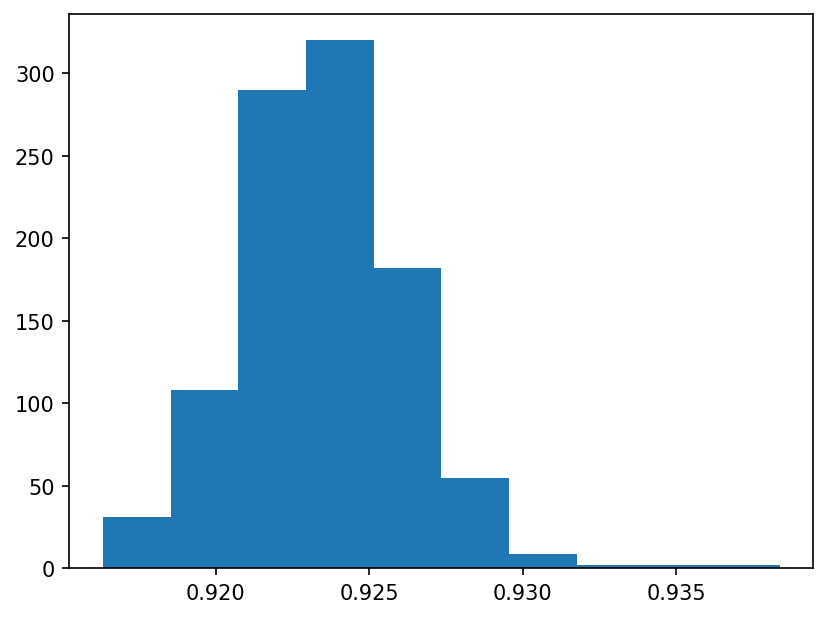

In [79]:
plt.hist(BDQ_HET_results["Accuracy"])

In [68]:
np.percentile(BDQ_results["Accuracy"], q=[2.5, 97.5])

array([0.92056108, 0.92936377])

In [52]:
os.path.join(analysis_dir, drug, "BINARY", path)

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/BINARY/tiers=1+2/phenos=ALL'

In [51]:
BDQ_results

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc,CV
0,0.845175,0.656608,0.944205,0.464996,0.924426,0.800407,0
1,0.840464,0.631463,0.945729,0.447389,0.925284,0.788596,1
2,0.843917,0.647716,0.943486,0.465015,0.922637,0.795601,2
3,0.840863,0.646377,0.946978,0.493727,0.924712,0.796677,3
4,0.843228,0.646444,0.944688,0.461883,0.924283,0.795566,4
...,...,...,...,...,...,...,...
996,0.839753,0.654255,0.945446,0.463801,0.925857,0.799851,996
997,0.844460,0.665635,0.943863,0.469091,0.924569,0.804749,997
998,0.851004,0.654088,0.943928,0.460857,0.924139,0.799008,998
999,0.841445,0.650054,0.946897,0.464037,0.927288,0.798475,999


In [8]:
# drug = "Moxifloxacin"
# MXF_results, MXF_HET_results = plot_everything_check_significance(drug, variable_lst=["Sensitivity", "Specificity", "AUC", "Balanced Accuracy"])#saveName_DROP="results/TBScience/BDQ_no_HETs.png", saveName_HET="results/TBScience/BDQ_with_HETs.png")

# Plot Statistics for a Single Model for all Drugs

In [6]:
def plot_single_model_all_drugs(paths_lst, 
                                hue_variable,
                                variable_lst, 
                                x_order=["Levofloxacin", "Moxifloxacin", "Bedaquiline", "Clofazimine", "Linezolid", "Delamanid", "Pretomanid"],
                                bootstrap=False, errorbar=None, include_het=False, palette="muted", sigfig=1, saveName=None
                               ):
        
    if include_het:
        model_prefix = "_HET"
        title_str = " +HET"
    else:
        model_prefix = ""
        title_str = " -HET"
            
    if bootstrap:
        model_prefix += "_bootstrap"

    concat_models = []
    for drug in x_order:
        
        for path in paths_lst:
            
            full_path = os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv")
            tier1_path = os.path.join(analysis_dir, drug, "BINARY", path.replace("1+2", "1"), f"model_stats_CV{model_prefix}.csv")

            if os.path.isfile(full_path):
                df = pd.read_csv(full_path)
                print(f"Tiers 1+2 for {drug}")
            elif os.path.isfile(tier1_path):
                df = pd.read_csv(tier1_path)
                print(f"Tier 1 for {drug}")
            else:
                df = pd.DataFrame({"AUC": 0, "Sens": 0, "Spec": 0, "Precision": 0, "Accuracy": 0, "Balanced_Acc": 0}, index=[0])
                print(f"No results for {drug}")
            
            df["Drug"] = drug
            df["F1"] = 2 / ((1 / df["Precision"]) + (1 / df["Sens"]))
            
            if len(paths_lst) > 1:
                df["Model"] = path_name_dict[path]

            concat_models.append(df)
            
    df_plot = pd.concat(concat_models, axis=0)
    
    if len(paths_lst) > 1:
        df_plot = df_plot.melt(id_vars=["Drug", "Model"])
    else:
        df_plot = df_plot.melt(id_vars=["Drug"])

    df_plot["variable"] = df_plot["variable"].replace("Sens", "Sensitivity").replace("Spec", "Specificity").replace("Balanced_Acc", "Balanced Accuracy")
    df_plot = df_plot.query("variable in @variable_lst")#.query("CV > 0")
    df_plot["value"] *= 100
    
    x_order = [drug for drug in x_order if drug in df_plot["Drug"].values]
    plot_width = 1.5 * len(df_plot["Drug"].unique())

    fig, ax = plt.subplots(figsize=(plot_width, 4.5))
    sns.barplot(data=df_plot,
                x="Drug",
                y="value",
                hue=hue_variable,
                edgecolor="black",
                linewidth=0.5,
                hue_order=variable_lst,
                order=x_order,
                errorbar=errorbar,
                errwidth=0.75,
                capsize=0.05,
                palette=palette,
                ax=ax
                )
    
    label_loc = 'center'

    if sigfig == 1:
        font_size = '7'
    else:
        font_size = '9'

    for cont in ax.containers:
        labels = [np.round(val, sigfig) if val > 0 else "" for val in cont.datavalues]    
        ax.bar_label(cont, labels=labels, label_type=label_loc, fontsize=font_size)

    plt.ylim(0, 100)
    # plt.title(f"{path}, {title_str}\n")
    plt.xlabel("")
    plt.ylabel("")
    # plt.legend(loc="upper right", fontsize=8)

    sns.move_legend(ax, fontsize=8, title='', loc='upper right', #bbox_to_anchor=(1.12, 0.6)
                    ncol=len(df_plot["variable"].unique()), bbox_to_anchor=(0.7, -0.3)
                   )
    sns.despine()
    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300)
        
    return df_plot

In [14]:
sns.color_palette("Set2").as_hex()

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

Tiers 1+2 for Levofloxacin
Tiers 1+2 for Moxifloxacin
Tiers 1+2 for Bedaquiline
Tiers 1+2 for Clofazimine
Tier 1 for Linezolid
Tiers 1+2 for Delamanid
Tier 1 for Pretomanid


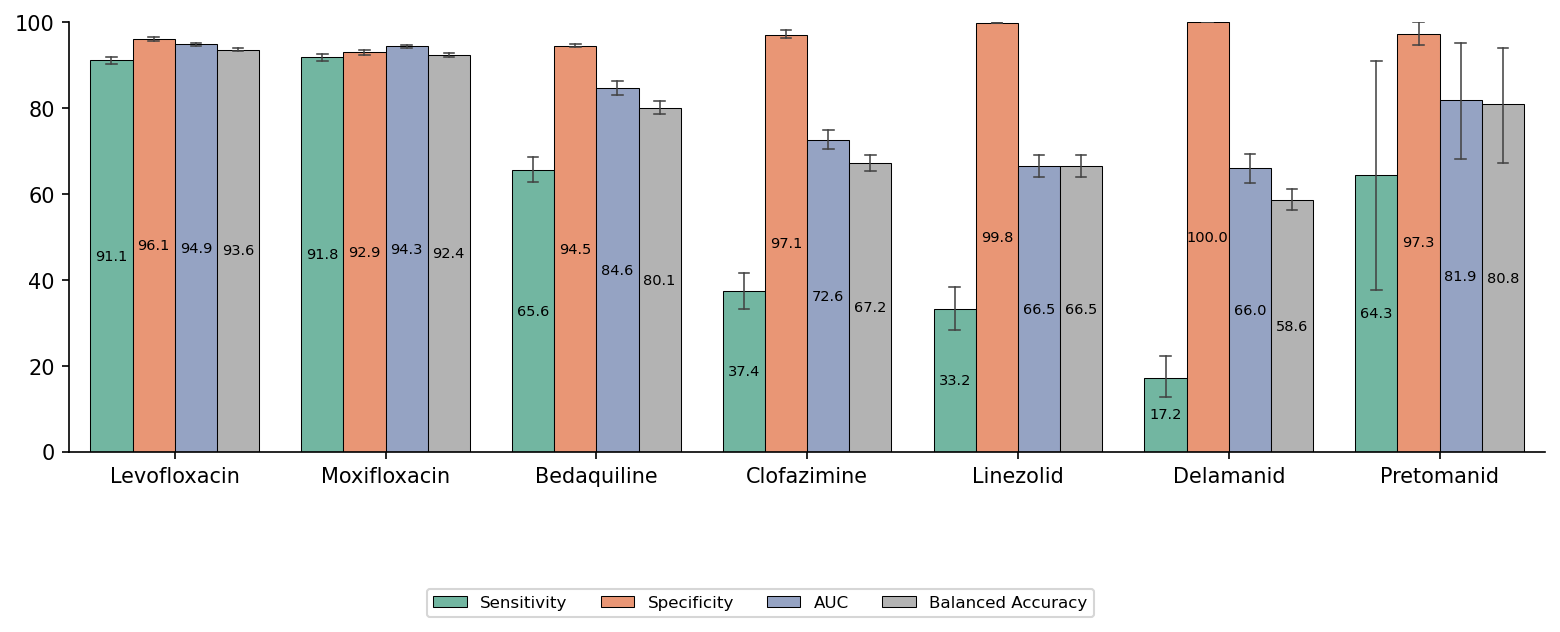

In [8]:
paths_lst = ['tiers=1+2/phenos=ALL']

tier1_ALL_results = plot_single_model_all_drugs(paths_lst, 
                                                hue_variable="variable",
                                                variable_lst=["Sensitivity", "Specificity", "AUC", "Balanced Accuracy"], 
                                                x_order=["Levofloxacin", "Moxifloxacin", "Bedaquiline", "Clofazimine", "Linezolid", "Delamanid", "Pretomanid"],
                                                bootstrap=True, errorbar=("pi", 95), include_het=False, palette=sns.color_palette("Set2").as_hex()[:3] + [sns.color_palette("Set2").as_hex()[-1]], 
                                                saveName="results/TBScience/binary_metrics_ALL.png"
                                               )

In [42]:
drug = "Moxifloxacin"
test = pd.read_csv(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/BINARY/tiers=1/phenos=ALL/model_stats_CV_bootstrap.csv")

In [43]:
for col in test.columns:
    
    if col in ["AUC", "Balanced_Acc"]:
        print(col, st.normaltest(test.query("CV > 0")[col]))

AUC NormaltestResult(statistic=15.417061163545391, pvalue=0.00044898073312713525)
Balanced_Acc NormaltestResult(statistic=14.399169779511409, pvalue=0.0007468957881274159)


(array([ 1.,  0.,  0.,  4., 10., 19., 32., 24.,  7.,  4.]),
 array([0.92825031, 0.92998017, 0.93171003, 0.93343989, 0.93516975,
        0.93689961, 0.93862948, 0.94035934, 0.9420892 , 0.94381906,
        0.94554892]),
 <BarContainer object of 10 artists>)

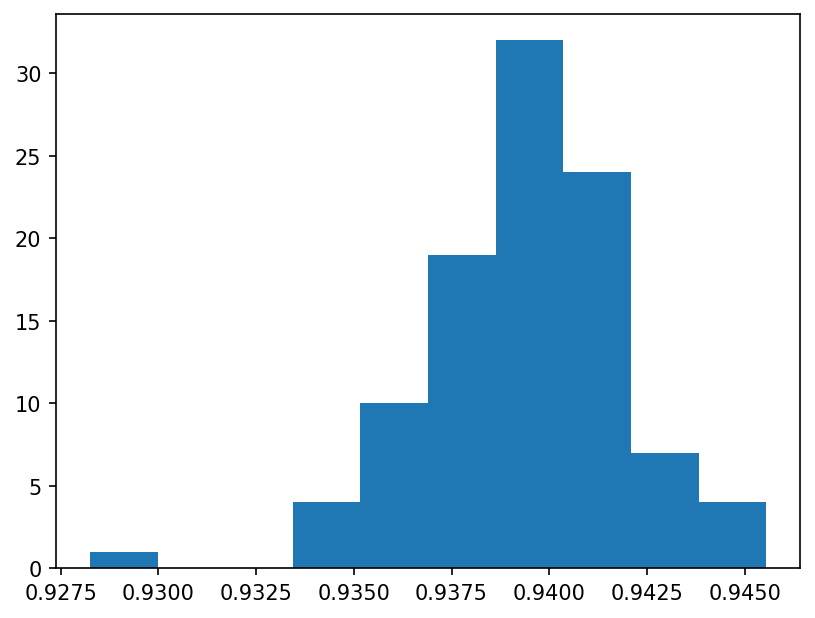

In [45]:
plt.hist(test["AUC"])

PTM: No Tier 2 genes
DLM: No significant WHO?
BDQ/MXF/LEV/CFZ: AUC+
BDQ/CFZ: Spec+
MXF/LEV: Sens+ and Spec-
BDQ: Sens-
LZD: No significant Tier 2 mutations

In [ ]:
#sns.histplot(data=LEV_results.query("variable=='Specificity' & Model.str.contains('ALL')"), x="value", hue="Model")